# Imports

In [216]:
import os
import gc
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle
from collections import Counter

from scipy.spatial.transform import Rotation as R

import open3d as o3d
from cuml.cluster import DBSCAN
import cupy as cp

import faiss

In [217]:
import torch
import torch.nn.functional as F

In [218]:
from scripts.iou import compute_3d_iou_accuracte_batch, compute_3d_iou, compute_iou_batch
from scripts.vis_live import visualize_and_capture

# Setup

In [219]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [220]:
def generate_pastel_color():
    # generate (r, g, b) tuple of random numbers between 0.5 and 1, truncate to 2 decimal places
    r = round(random.uniform(0.5, 1), 2)
    g = round(random.uniform(0.5, 1), 2)
    b = round(random.uniform(0.5, 1), 2)
    return (r, g, b)

In [221]:
'''
img_dict = {img_name: {img_path: str,
                        ram_tags: list_of_str,
                        objs: {0: {bbox: [x1, y1, x2, y2],
                                    phrase: str,
                                    clip_embed: [1, 1024]},
                                    dino_embed: [1, 1024]},
                                    mask: [h, w],
                                    prob: float,
                                    aabb: arr}
                                1: {...},
                        }
            img_name: {...},
            }
'''

def get_depth(img_name, depth_scale):
    # depth_path = os.path.join(depth_dir, img_name + '.npy')
    # depth = np.load(depth_path)

    depth_path = os.path.join(depth_dir, img_name + '.png')
    depth = cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH)
    depth = depth.astype(np.float32) / depth_scale
    return depth

def get_pose(img_name):
    pose_path = os.path.join(pose_dir, img_name + '.txt')

    # check if the pose file exists, if it doesn't, return None
    # [x, y, z, qx, qy, qz, qw]
    if not os.path.exists(pose_path):
        return None
    
    with open(pose_path, 'r') as f:
        pose = f.read().split()
        pose = np.array(pose).astype(np.float32)

        #change pose from [x, y, z, qw, qx, qy, qz] to [x, y, z, qx, qy, qz, qw]
        pose = np.concatenate((pose[:3], pose[4:], pose[3:4]))
    return pose

def get_sim_cam_mat_with_fov(h, w, fov):
    cam_mat = np.eye(3)
    cam_mat[0, 0] = cam_mat[1, 1] = w / (2.0 * np.tan(np.deg2rad(fov / 2)))
    cam_mat[0, 2] = w / 2.0
    cam_mat[1, 2] = h / 2.0
    return cam_mat

def get_realsense_cam_mat():
    K = np.array([[386.458, 0, 321.111],
              [0, 386.458, 241.595],
              [0, 0, 1]])
    return K

def get_kinect_cam_mat():
    K = np.array([[9.7096624755859375e+02, 0., 1.0272059326171875e+03], 
                  [0., 9.7109600830078125e+02, 7.7529718017578125e+02], 
                  [0., 0., 1]]) #for wheel
    
    # K = np.array([[5.0449380493164062e+02, 0., 3.3090179443359375e+02], 
    #               [0., 5.0470922851562500e+02, 3.1253039550781250e+02], 
    #               [0., 0., 1.]]) # for handheld
    return K

def get_ipad_cam_mat():
    K = np.array([[7.9555474853515625e+02, 0., 3.6264770507812500e+02], 
                  [0., 7.9555474853515625e+02, 4.7412319946289062e+02], 
                  [0., 0., 1.]])
    
    # Downsample factor
    downsample_factor = 3.75

    # Scale down the camera matrix
    scaled_K = K.copy()
    scaled_K[0, 0] /= downsample_factor  # fx
    scaled_K[1, 1] /= downsample_factor  # fy
    scaled_K[0, 2] /= downsample_factor  # cx
    scaled_K[1, 2] /= downsample_factor  # cy
    
    return scaled_K

def get_iphone_cam_mat():
    K = np.array([[6.6585675048828125e+02, 0., 3.5704681396484375e+02], 
                 [0., 6.6585675048828125e+02, 4.8127374267578125e+02], 
                 [0., 0., 1. ]])
    
    # Downsample factor
    downsample_factor = 3.75

    # Scale down the camera matrix
    scaled_K = K.copy()
    scaled_K[0, 0] /= downsample_factor  # fx
    scaled_K[1, 1] /= downsample_factor  # fy
    scaled_K[0, 2] /= downsample_factor  # cx
    scaled_K[1, 2] /= downsample_factor  # cy

    return scaled_K

def get_mp3d_cam_mat():
    K = np.array([[ 400.,    0., 400.],
                  [   0., 400., 400.],
                  [   0.,    0.,    1.]])
    return K


In [222]:
def create_point_cloud(img_id, obj_data, cam_mat, color=(1, 0, 0), cam_height=1.5, depth_scale=1000.0):
    """
    Generates a point cloud from a depth image, camera intrinsics, mask, and pose.
    Only points within the mask and with valid depth are added to the cloud.
    Points are colored using the specified color.
    """
    depth = get_depth(img_id, depth_scale=depth_scale)
    pose = get_pose(img_id)
    mask = obj_data['mask']

    if pose is None:
        return o3d.geometry.PointCloud()

    # Reproject the depth to 3D space
    rows, cols = np.where(mask)

    
    depth_values = depth[rows, cols]
    valid_depth_indices = (depth_values > 0) & (depth_values <= 10)

    rows = rows[valid_depth_indices]
    cols = cols[valid_depth_indices]
    depth_values = depth_values[valid_depth_indices]

    points2d = np.vstack([cols, rows, np.ones_like(rows)])

    cam_mat_inv = np.linalg.inv(cam_mat)
    points3d_cam = cam_mat_inv @ points2d * depth_values
    points3d_homo = np.vstack([points3d_cam, np.ones((1, points3d_cam.shape[1]))])

    # Parse the pose
    pos = np.array(pose[:3], dtype=float).reshape((3, 1))
    quat = pose[3:]
    rot = R.from_quat(quat).as_matrix()

    # Apply rotation correction, to match the orientation z: backward, y: upward, and x: right
    rot_ro_cam = np.eye(3)
    rot_ro_cam[1, 1] = -1
    rot_ro_cam[2, 2] = -1
    rot = rot @ rot_ro_cam

    # # Apply position correction
    # pos[2] += cam_height

    # Create the pose matrix
    pose_matrix = np.eye(4)
    pose_matrix[:3, :3] = rot
    pose_matrix[:3, 3] = pos.reshape(-1)

    points3d_global_homo = pose_matrix @ points3d_homo
    points3d_global = points3d_global_homo[:3, :]

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points3d_global.T)
    pcd.colors = o3d.utility.Vector3dVector(np.tile(color, (points3d_global.shape[1], 1)))

    return pcd


In [223]:
def fast_DBSCAN(point_cloud_o3d, eps=0.2, min_samples=20):

    if point_cloud_o3d.is_empty():
        return point_cloud_o3d

    # Convert Open3D point cloud to NumPy arrays
    points_np = np.asarray(point_cloud_o3d.points)
    colors_np = np.asarray(point_cloud_o3d.colors)

    # depending on number of points, choose int32 or int64
    

    # Convert NumPy array to CuPy array for GPU computations
    points_gpu = cp.asarray(points_np)

    # Create a DBSCAN instance with cuML
    dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)

    # Fit the model to the GPU data
    dbscan_model.fit(points_gpu)

    # Get the labels for the clusters
    labels_gpu = dbscan_model.labels_

    # Convert the labels back to a NumPy array
    labels = cp.asnumpy(labels_gpu)

    # Count the occurrence of each label to find the largest cluster
    label_counter = Counter(labels)
    label_counter.pop(-1, None)  # Remove the noise label (-1)
    if not label_counter:  # If all points are noise, return an empty point cloud
        return o3d.geometry.PointCloud()

    # Find the label of the largest cluster
    largest_cluster_label = max(label_counter, key=label_counter.get)

    # Filter the points and colors that belong to the largest cluster
    largest_cluster_points = points_np[labels == largest_cluster_label]
    largest_cluster_colors = colors_np[labels == largest_cluster_label]

    # Create a new Open3D point cloud with the points and colors of the largest cluster
    largest_cluster_point_cloud_o3d = o3d.geometry.PointCloud()
    largest_cluster_point_cloud_o3d.points = o3d.utility.Vector3dVector(largest_cluster_points)
    largest_cluster_point_cloud_o3d.colors = o3d.utility.Vector3dVector(largest_cluster_colors)

    return largest_cluster_point_cloud_o3d


In [224]:
def custom_cosine_similarity(vec1, vec2):
    # Ensure the vectors have the same shape
    if vec1.shape != vec2.shape:
        raise ValueError("Vectors must have the same shape.")

    # Compute the dot product of the vectors
    dot_product = np.dot(vec1, vec2)

    # Compute the magnitudes (Euclidean norms) of the vectors
    magnitude_vec1 = np.linalg.norm(vec1)
    magnitude_vec2 = np.linalg.norm(vec2)

    # Compute the cosine similarity
    similarity = dot_product / (magnitude_vec1 * magnitude_vec2)

    # Normalize the similarity value to [0, 1]
    normalized_similarity = 0.5 * (similarity + 1)

    return normalized_similarity

In [225]:
# Function to convert Open3D point cloud to NumPy array
def pointcloud_to_numpy(pcd):
    return np.asarray(pcd.points)
    # return np.asarray(pcd.points), np.asarray(pcd.colors)

# Function to convert NumPy array to Open3D point cloud
def numpy_to_pointcloud(points):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    return pcd


In [226]:
def vanilla_icp(source, target, params):
    # Set ICP configuration
    config = o3d.pipelines.registration.ICPConvergenceCriteria(relative_fitness=1e-6,
                                                            relative_rmse=1e-6, max_iteration=params['icp_max_iter'])
    
    icp_threshold = params['voxel_size'] * params['icp_threshold_multiplier']

    # Run ICP
    result_icp = o3d.pipelines.registration.registration_icp(
        source, target, icp_threshold, np.eye(4),
        o3d.pipelines.registration.TransformationEstimationPointToPoint(),
        config)
    
    # Update pcd based on the transformation matrix obtained from ICP
    source.transform(result_icp.transformation)
    return source

In [227]:
# # Load the model
# model, transform = clip.load("ViT-B/32", device=device)

# def get_text_clip_embedding(text):
#     text_inputs = clip.tokenize([text]).to(device)
    
#     # Get the text features
#     with torch.no_grad():
#         text_features = model.encode_text(text_inputs)
        
#     # Normalize the features
#     text_features /= text_features.norm(dim=-1, keepdim=True)
    
#     return text_features.cpu().squeeze().numpy()

# ceiling_embed = get_text_clip_embedding("This is an image of a ceiling")
# wall_embed = get_text_clip_embedding("This is an image of a wall")
# floor_embed = get_text_clip_embedding("This is an image of floor")
# chair_embed = get_text_clip_embedding("This is an image of a chair")
# background_embed = get_text_clip_embedding("This is an image of a ceiling or wall or floor or pillar")

# del model
# del transform
# torch.cuda.empty_cache()
# gc.collect()


# Obj Nodes Creation

In [228]:
def process_pcd(pcd, params, run_dbscan=True):
    pcd = pcd.voxel_down_sample(voxel_size=params['voxel_size'])

    if run_dbscan:
        pcd = fast_DBSCAN(pcd, eps=params['eps'], min_samples=params['min_samples'])

    # points = np.asarray(pcd.points)
    # colors = np.asarray(pcd.colors)  # Assuming your point cloud has colors

    # # Filter out points below the ground plane and above the ceiling plane
    # mask = (points[:, 1] >= 0) & (points[:, 1] <= 2)
    # points_filtered = points[mask]
    # colors_filtered = colors[mask]

    # # Create a new point cloud with the filtered points
    # pcd_filtered = o3d.geometry.PointCloud()
    # pcd_filtered.points = o3d.utility.Vector3dVector(points_filtered)
    # pcd_filtered.colors = o3d.utility.Vector3dVector(colors_filtered)
    
    return pcd

def get_bounding_box(pcd, params):
    try:
        return pcd.get_oriented_bounding_box(robust=True)
    except RuntimeError as e:
        # print(f"Met {e}, use axis aligned bounding box instead")
        return pcd.get_axis_aligned_bounding_box()

def check_background(obj_data):
    # background_words = ['ceiling', 'wall', 'floor', 'pillar', 'door', 'basement', 'room', 'workshop', 'warehouse', 'building']
    # background_phrase = ['office']

    background_words = ['room', 'rooms']
    background_phrase = []
    
    obj_phrase = obj_data['phrase']
    if obj_phrase in background_phrase:
        return True

    obj_words = obj_phrase.split()
    for word in obj_words:
        if word in background_words:
            return True
    return False

In [229]:
def merge_nodes(node1, node2, params, run_icp=False):
    # Merge source IDs: source_ids: [(img_id, obj_id), ...]
    source_ids = node1['source_ids'] + node2['source_ids']
    count = len(source_ids)

    # Average the embeddings
    avg_clip_embed = (np.array(node1['clip_embed']) * len(node1['source_ids']) +
                      np.array(node2['clip_embed']) * len(node2['source_ids'])) / count

    avg_dino_embed = (np.array(node1['dino_embed']) * len(node1['source_ids']) +
                      np.array(node2['dino_embed']) * len(node2['source_ids'])) / count
    
    if run_icp:
        node2['pcd'] = vanilla_icp(node2['pcd'], node1['pcd'], params)

    # Combine point clouds
    merged_pcd = node1['pcd']
    merged_pcd.points.extend(node2['pcd'].points)

    # make all points the same color (node1's color)
    color = generate_pastel_color()
    merged_pcd.colors = o3d.utility.Vector3dVector(np.tile(color, (len(merged_pcd.points), 1)))
    merged_pcd = process_pcd(merged_pcd, params)

    bbox = get_bounding_box(merged_pcd, params)

    # Concatenate the points contributions from both nodes
    points_contri = node1['points_contri'] + node2['points_contri']

    return {
        'source_ids': source_ids,
        'clip_embed': avg_clip_embed,
        'dino_embed': avg_dino_embed,
        'pcd': merged_pcd,
        'bbox': bbox,
        'points_contri': points_contri
    }

In [230]:
def init_scene_nodes(img_data, img_id, params):
    # Initialize an empty dictionary to store scene object nodes
    scene_obj_nodes = {}

    # Retrieve the initial image data using the provided ID
    img_path = img_data['img_path']

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert image from BGR to RGB format

    # Retrieve objects present in the image
    objs = img_data['objs']
    node_count = 1

    for obj_id in objs.keys():
        obj_data = objs[obj_id]

        # Calculate similarities
        check_background_flag = check_background(obj_data)
        
        if check_background_flag:
            node_id = 0
            continue # Skipping the background objects for now
        else:
            node_id = node_count
            node_count += 1
        
        color = generate_pastel_color()
        pcd = create_point_cloud(img_id, obj_data, params['cam_mat'], color=color, cam_height=params['cam_height'], depth_scale=params['depth_scale'])
        pcd = process_pcd(pcd, params)

        bbox = get_bounding_box(pcd, params)
        if bbox.volume() < 1e-6 or len(pcd.points) < 10:
            continue
        
        # Store the object data in the scene object nodes dictionary
        scene_obj_nodes[node_id] = {'source_ids': [(img_id, obj_id)], 
                                    'clip_embed': objs[obj_id]['clip_embed'], 
                                    'dino_embed': objs[obj_id]['dino_embed'], 
                                    'pcd': pcd, 
                                    'bbox': bbox,
                                    'points_contri': [len(pcd.points)]}  # Count of points in the point cloud

    # print("Number of nodes in the scene: ", len(scene_obj_nodes))
    return scene_obj_nodes


In [231]:
def compute_overlap_matrix_2set(scene_obj_nodes, det_nodes, params):
    '''
    Compute pairwise overlapping between two sets of objects in terms of point nearest neighbor.
    scene_obj_nodes is the existing objects in the scene, det_nodes is the new objects to be added to the scene
    '''

    m = len(scene_obj_nodes)
    n = len(det_nodes)
    overlap_matrix = np.zeros((m, n))

    # Convert the point clouds into numpy arrays and then into FAISS indices for efficient search
    points_map = [np.asarray(obj['pcd'].points, dtype=np.float32) for obj in scene_obj_nodes.values()]
    indices = [faiss.IndexFlatL2(arr.shape[1]) for arr in points_map] # m indices
    
    # Add the points from the numpy arrays to the corresponding FAISS indices
    for index, arr in zip(indices, points_map):
        index.add(arr)
        
    points_new = [np.asarray(obj['pcd'].points, dtype=np.float32) for obj in det_nodes.values()]
    
    # Assuming you can compute 3D IoU given the 'bbox' field in your dicts
    bbox_map_np = np.array([obj['bbox'].get_box_points() for obj in scene_obj_nodes.values()])
    bbox_map = torch.from_numpy(bbox_map_np).to(device)

    bbox_new_np = np.array([obj['bbox'].get_box_points() for obj in det_nodes.values()])
    bbox_new = torch.from_numpy(bbox_new_np).to(device)
    
    try:
        # Assuming you have a function called compute_3d_iou_accurate_batch that takes PyTorch tensors
        iou = compute_3d_iou_accuracte_batch(bbox_map, bbox_new)  # (m, n)
    except ValueError:
        # If you encounter the "Plane vertices are not coplanar" error, switch to axis-aligned bounding boxes
        bbox_map = []
        bbox_new = []
        
        for node in scene_obj_nodes.values():
            bbox_map.append(np.asarray(
                node['pcd'].get_axis_aligned_bounding_box().get_box_points()
            ))

        for node in det_nodes.values():
            bbox_new.append(np.asarray(
                node['pcd'].get_axis_aligned_bounding_box().get_box_points()
            ))
        
        bbox_map = torch.tensor(np.stack(bbox_map))
        bbox_new = torch.tensor(np.stack(bbox_new))
        
        # Assuming you have a function called compute_iou_batch that takes PyTorch tensors
        iou = compute_iou_batch(bbox_map, bbox_new)  # (m, n)


    # Compute the pairwise overlaps
    for i in range(m):
        for j in range(n):
            if iou[i, j] < 1e-6:
                continue
            
            D, I = indices[i].search(points_new[j], 1)  # Search new object j in map object i

            overlap = (D < params['voxel_size'] ** 2).sum()  # D is the squared distance

            # Calculate the ratio of points within the threshold
            overlap_matrix[i, j] = overlap / len(points_new[j])

    return overlap_matrix

def compute_spatial_similarity(scene_obj_nodes, det_nodes, params):
    spatial_sim = compute_overlap_matrix_2set(scene_obj_nodes, det_nodes, params)
    spatial_sim = torch.from_numpy(spatial_sim).T
    spatial_sim = spatial_sim.to(device)

    return spatial_sim

def compute_visual_similarity(scene_obj_nodes, det_nodes, params):
    '''
    Compute the visual similarities between the detections and the objects.
    
    Args:
        scene_obj_nodes: a dict of N objects in the scene
        det_nodes: a dict of M detections
    Returns:
        A MxN tensor of visual similarities
    '''
    
    # Extract clip embeddings from scene_obj_nodes and det_nodes dictionaries
    embed_type = params['embed_type']
    obj_fts = np.array([obj[embed_type] for obj in scene_obj_nodes.values()]) # (N, D)
    det_fts = np.array([obj[embed_type] for obj in det_nodes.values()]) # (M, D)

    obj_fts = torch.from_numpy(obj_fts).to(device)
    det_fts = torch.from_numpy(det_fts).to(device)
    
    # Reshape tensors to match dimensions for cosine similarity
    det_fts = det_fts.unsqueeze(-1)  # (M, D, 1)
    obj_fts = obj_fts.T.unsqueeze(0)  # (1, D, N)

    # Compute cosine similarity
    visual_sim = F.cosine_similarity(det_fts, obj_fts, dim=1)  # (M, N)
    
    # Scale the visual similarity to be between 0 and 1
    # scaled_visual_sim = (visual_sim + 1) / 2
    
    return visual_sim

def compute_aggregate_similarity(scene_obj_nodes, det_nodes, params):
    '''
    Compute the aggregate similarity between the detections and the objects.
    
    Args:
        scene_obj_nodes: a dict of N objects in the scene
        det_nodes: a dict of M detections
    Returns:
        A MxN tensor of aggregate similarities
    '''

    spatial_sim = compute_spatial_similarity(scene_obj_nodes, det_nodes, params)
    visual_sim  = compute_visual_similarity(scene_obj_nodes, det_nodes, params)
    aggregate_sim = (1 + params['alpha']) * visual_sim + (1 - params['alpha']) * spatial_sim

    # if value in row is less than threshold, set it to -inf
    aggregate_sim[aggregate_sim < params['sim_threshold']] = -float('inf')

    return aggregate_sim, spatial_sim, visual_sim

In [232]:
def update_scene_nodes(img_id, img_data, scene_obj_nodes, params):
    det_nodes = init_scene_nodes(img_data, img_id, params)  # Assuming img_data should be used
    
    if len(det_nodes) == 0:
        return scene_obj_nodes
    
    # Assuming you have a function named compute_aggregate_similarity to get aggregate similarity
    aggregate_sim, _, _ = compute_aggregate_similarity(scene_obj_nodes, det_nodes, params)
    
    # Initialize a new dictionary to store updated scene_obj_nodes
    updated_scene_obj_nodes = scene_obj_nodes.copy()
    
    # Find the maximum existing key in scene_obj_nodes
    max_scene_key = max(scene_obj_nodes.keys(), default=0)
    
    # Iterate through all detected nodes to merge them into existing scene_obj_nodes
    for i, det_key in enumerate(det_nodes.keys()):
        # If not matched to any object in the scene, add it as a new object
        if aggregate_sim[i].max() == float('-inf'):
            new_key = max_scene_key + det_key  # Create a new unique key
            updated_scene_obj_nodes[new_key] = det_nodes[det_key]
        else:
            # Merge with most similar existing object in the scene
            j = aggregate_sim[i].argmax().item()
            scene_key = list(scene_obj_nodes.keys())[j]
            matched_det = det_nodes[det_key]
            matched_obj = scene_obj_nodes[scene_key]
            
            # Merge the matched detection node into the matched scene node
            updated_scene_obj_nodes[scene_key] = merge_nodes(matched_obj, matched_det, params)

    # print("Number of nodes in the scene: ", len(updated_scene_obj_nodes))
    
    return updated_scene_obj_nodes

In [233]:
def filter_scene_nodes(scene_obj_nodes, params):
    print("Before filtering:", len(scene_obj_nodes))
    
    # Initialize a new dictionary to store the filtered scene_obj_nodes
    filtered_scene_obj_nodes = {}
    
    for key, obj in scene_obj_nodes.items():
        # Use len(obj['pcd'].points) to get the number of points and len(obj['source_ids']) to get the number of views
        if len(obj['pcd'].points) >= params['obj_min_points'] and len(obj['source_ids']) >= params['obj_min_detections']:
            filtered_scene_obj_nodes[key] = obj

    print("After filtering:", len(filtered_scene_obj_nodes))
    
    return filtered_scene_obj_nodes


In [234]:
def compute_overlap_matrix_nodes(params, scene_obj_nodes):
    n = len(scene_obj_nodes)
    overlap_matrix = np.zeros((n, n))
    
    point_arrays = [np.asarray(obj['pcd'].points, dtype=np.float32) for obj in scene_obj_nodes.values()]
    indices = [faiss.IndexFlatL2(arr.shape[1]) for arr in point_arrays]
    
    for index, arr in zip(indices, point_arrays):
        index.add(arr)
    
    for i, obj_i in enumerate(scene_obj_nodes.values()):
        for j, obj_j in enumerate(scene_obj_nodes.values()):
            if i != j:
                box_i = obj_i['bbox']
                box_j = obj_j['bbox']

                if params['merge_overlap_method'] == 'iou':
                    iou = compute_3d_iou(box_i, box_j)
                    overlap_matrix[i, j] = iou

                elif params['merge_overlap_method'] == 'max_overlap':
                    iou = compute_3d_iou(box_i, box_j, use_iou=False)
                    overlap_matrix[i, j] = iou
                    
                elif params['merge_overlap_method'] == 'nnratio':
                    iou = compute_3d_iou(box_i, box_j)
                    if iou == 0:
                        continue
                    
                    D, I = indices[j].search(point_arrays[i], 1)
                    overlap = (D < params['voxel_size'] ** 2).sum()
                    overlap_matrix[i, j] = overlap / len(point_arrays[i])
    
    return overlap_matrix

def merge_overlap_nodes(params, scene_obj_nodes, overlap_matrix):
    x, y = overlap_matrix.nonzero()
    overlap_ratio = overlap_matrix[x, y]
    
    sort = np.argsort(overlap_ratio)[::-1]
    x = x[sort]
    y = y[sort]
    overlap_ratio = overlap_ratio[sort]
    
    kept_keys = list(scene_obj_nodes.keys())
    merged_keys = set()  # Keep track of keys that have been merged into others
    
    for i, j, ratio in zip(x, y, overlap_ratio):
        key_i = kept_keys[i]
        key_j = kept_keys[j]
        
        # Skip if these keys have been merged into others
        if key_i in merged_keys or key_j in merged_keys:
            continue

        embed_type = params['embed_type']
        visual_sim = F.cosine_similarity(
            torch.tensor(scene_obj_nodes[key_i][embed_type]).to(device),
            torch.tensor(scene_obj_nodes[key_j][embed_type]).to(device),
            dim=0
        )

        overall_sim = (1 + params['alpha']) * visual_sim + (1 - params['alpha']) * ratio
        
        if overall_sim > params['merge_overall_thresh']:
            if key_j in scene_obj_nodes: # Check if key_j still exists
                # scene_obj_nodes[key_j] = merge_nodes(scene_obj_nodes[key_j], scene_obj_nodes[key_i], params, run_icp=False)
                scene_obj_nodes[key_j] = merge_nodes(scene_obj_nodes[key_j], scene_obj_nodes[key_i], params, run_icp=False)
                del scene_obj_nodes[key_i]
                merged_keys.add(key_i)  # Mark key_i as merged
    
    return scene_obj_nodes

def merge_scene_nodes(scene_obj_nodes, params):
    if params['merge_overall_thresh'] > 0:
        print("Before merging:", len(scene_obj_nodes))
        
        # Compute the overlap matrix
        overlap_matrix = compute_overlap_matrix_nodes(params, scene_obj_nodes)
        
        # Merge overlapping nodes
        scene_obj_nodes = merge_overlap_nodes(params, scene_obj_nodes, overlap_matrix)
        
        print("After merging:", len(scene_obj_nodes))
    
    return scene_obj_nodes

In [235]:
def remove_empty_nodes(scene_obj_nodes, params):
    # Initialize a new dictionary to store the filtered scene_obj_nodes
    filtered_scene_obj_nodes = {}
    
    for key, obj in scene_obj_nodes.items():
        if len(obj['pcd'].points) > 10:
            filtered_scene_obj_nodes[key] = obj

    return filtered_scene_obj_nodes

# Execution

In [253]:
weights_dir = "/scratch/kumaraditya_gupta/checkpoints/"

dataset_dir = "/scratch/kumaraditya_gupta/Datasets/mp3d_train/kEZ7cmS4wCh/sequence2/"
version = "v2"

imgs_dir = os.path.join(dataset_dir, "color")
depth_dir = os.path.join(dataset_dir, "depth")
pose_dir =  os.path.join(dataset_dir, "pose")

output_dir = os.path.join(dataset_dir, f"output_{version}")
img_dict_dir = os.path.join(output_dir, "img_dict.pkl")

# Load from pickle file
with open(img_dict_dir, 'rb') as file:
    img_dict = pickle.load(file)

# scene_obj_node_path = os.path.join(dataset_dir, "output_v1/scene_obj_nodes.pkl")
# with open(scene_obj_node_path, 'rb') as file:
#     scene_obj_nodes = pickle.load(file)

In [249]:
params = {'init_img_id': '001', #initialize the scene with this image

          'depth_scale': 655.35, #depth scale for converting depth image to meters (std value: 1000.0)
          
          'voxel_size': 0.05, #voxel size for downsampling point clouds (std value: 0.025, 0.05, 0.1)
          'eps': 0.125, #eps for DBSCAN (std value: 0.075, 0.125, 0.25)
          'min_samples': 10, #min_samples for DBSCAN (std value: 10)
          'embed_type': 'dino_embed', #embedding type to use for visual similarity
          
          'sim_threshold': 1.2, #threshold for aggregate similarity while running update_scene_nodes (0.95)
          'alpha': 0, #weight for visual similarity while computing aggregate similarity

          'merge_overlap_method': 'nnratio', #metric to use for merging overlapping nodes
          'merge_overall_thresh' : 1.2, #threshold for overall similarity while merging nodes in scene (0.95)

          'obj_min_points': 50, #minimum number of points in a node while filtering scene nodes
          'obj_min_detections': 3, #minimum number of detections in a node while filtering scene nodes

          'icp_threshold_multiplier': 1.5, #threshold multiplier for ICP
          'icp_max_iter': 2000, #maximum number of iterations for ICP

          'cam_mat': get_sim_cam_mat_with_fov(900, 900, 90), #camera matrix
          'cam_height': 1.5, #camera height

          'img_size': (900, 900), #image size
          'save_folder': '/scratch/kumaraditya_gupta/kinect_output_imgs/' #for vis, not being used right now
          }

In [239]:
# take only first 100 entries of img_dict
# stride = 3
# max_imgs = 50
# img_dict = {k: v for i, (k, v) in enumerate(img_dict.items()) if i % stride == 0}
# img_dict = {k: img_dict[k] for k in list(img_dict)[:max_imgs]}

In [240]:
# # for every img, modify the img_path from /scratch/kumaradi.gupta/run_kinect_wheel_2/rgb/1.png to /scratch/kumaradi.gupta/Datasets/kinect_wheel_2/rgb/1.png
# for img_id, img_data in tqdm(img_dict.items()):
#     img_data['img_path'] = img_data['img_path'].replace('/scratch/kumaradi.gupta/run_iphone', '/scratch/kumaradi.gupta/Datasets/run_iphone')

# print(img_dict['1']['img_path'])

In [254]:
scene_obj_nodes = init_scene_nodes(img_dict[params['init_img_id']], 
                                    params['init_img_id'], 
                                    params)

# visualize_and_capture(params['init_img_id'], scene_obj_nodes, params)
print("Number of nodes in the scene: ", len(scene_obj_nodes))

Number of nodes in the scene:  1


In [255]:
counter = 0

for img_id, img_data in tqdm(img_dict.items()):
    if len(img_data['objs']) == 0 or img_id == params['init_img_id']:
        continue
    
    scene_obj_nodes = update_scene_nodes(img_id, img_data, scene_obj_nodes, params)
    scene_obj_nodes = remove_empty_nodes(scene_obj_nodes, params)
    
    counter += 1
    if counter % 25 == 0:
        scene_obj_nodes = merge_scene_nodes(scene_obj_nodes, params)
        scene_obj_nodes = remove_empty_nodes(scene_obj_nodes, params)
        
    # visualize_and_capture(img_id, scene_obj_nodes, params)


  0%|          | 0/262 [00:00<?, ?it/s]

Before merging: 6
After merging: 5
Before merging: 12
After merging: 10
Before merging: 14
After merging: 14
Before merging: 19
After merging: 18
Before merging: 22
After merging: 19
Before merging: 23
After merging: 23
Before merging: 24
After merging: 24
Before merging: 31
After merging: 25
Before merging: 29
After merging: 28
Before merging: 37
After merging: 33


In [256]:
scene_obj_nodes = merge_scene_nodes(scene_obj_nodes, params)
scene_obj_nodes = filter_scene_nodes(scene_obj_nodes, params)

Before merging: 33
After merging: 33
Before filtering: 33
After filtering: 25


In [213]:
# remove_ids = []

# for node_id, node_data in scene_obj_nodes.items():
#     pcd = node_data['pcd']

#     # Filter out points where y < 0
#     points = np.asarray(pcd.points)
#     colors = np.asarray(pcd.colors)  # Assuming your point cloud has colors
#     mask = points[:, 1] >= -1.2
#     points_filtered = points[mask]
#     colors_filtered = colors[mask]
    
#     if len(points_filtered) < 10:
#         # If fewer than 10 points remain, delete the node
#         remove_ids.append(node_id)
#     else:
#         # Update the point cloud and save it
#         pcd.points = o3d.utility.Vector3dVector(points_filtered)
#         pcd.colors = o3d.utility.Vector3dVector(colors_filtered)

#         node_data['pcd'] = pcd  # Update the point cloud in your data structure

# for node_id in remove_ids:
#     del scene_obj_nodes[node_id]


In [257]:
save_pcd_dir = os.path.join(output_dir, "pcds")
if not os.path.exists(save_pcd_dir):
    os.makedirs(save_pcd_dir)

print("Number of objs in the scene: ", len(scene_obj_nodes))
for node_id, node_data in scene_obj_nodes.items():
    pcd_path = os.path.join(save_pcd_dir, f"{node_id}.pcd")
    o3d.io.write_point_cloud(pcd_path, node_data['pcd'])
    node_data['pcd'] = pcd_path  # Replace the Open3D object with the file path
    node_data['bbox'] = np.array(node_data['bbox'].get_box_points())  # Convert the Open3D bounding box to a NumPy array


Number of objs in the scene:  25


In [258]:
# Save the modified dictionary using pickle
with open(os.path.join(output_dir, 'scene_obj_nodes.pkl'), 'wb') as f:
    pickle.dump(scene_obj_nodes, f)

# Experiments

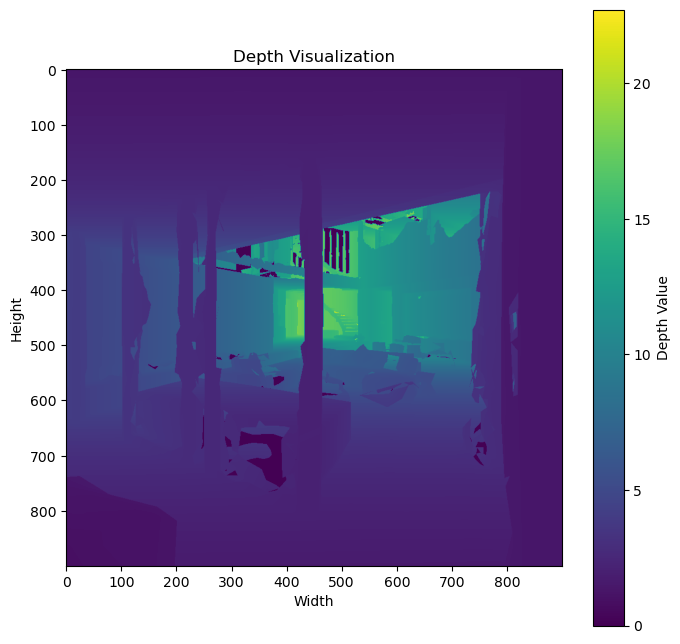

In [65]:
img_id = '019'
depth_data = get_depth(img_id, depth_scale=655.35)

# only keep the depth values that are within the valid range
# depth_data[depth_data < 0] = 0
# depth_data[depth_data > 3] = 0

# Visualize the depth data as a heatmap
plt.figure(figsize=(8, 8))
plt.imshow(depth_data, cmap='viridis')  # You can choose different colormaps like 'gray', 'plasma', etc.
plt.colorbar(label='Depth Value')
plt.title('Depth Visualization')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()


In [ ]:
node_id_1 = 1
node_id_2 = 164

sources = scene_obj_nodes[node_id_1]['source_ids']
points_contri = scene_obj_nodes[node_id_1]['points_contri']

# get the sources for top 5 points_contri
points_contri = np.array(points_contri)
top_5_idx = np.argsort(points_contri)[::-1][:5]
sources = [sources[i] for i in top_5_idx]

for source in sources:
    img_id, obj_id = source
    print(img_dict[img_id]['objs'][obj_id]['phrase'])

# print(f"Node 1 sources: {scene_obj_nodes[node_id_1]['source_ids']}")
# pcd1_img_id, pcd1_obj_id = scene_obj_nodes[node_id_1]['source_ids'][0]
# print(img_dict[pcd1_img_id]['objs'][pcd1_obj_id]['phrase'])

# print(f"Node 2 sources: {scene_obj_nodes[node_id_2]['source_ids']}")
# pcd2_img_id, pcd1_obj_id = scene_obj_nodes[node_id_2]['source_ids'][1]
# print(img_dict[pcd2_img_id]['objs'][pcd1_obj_id]['phrase'])


# # make a new scene_obj_nodes with only the two nodes
# node1 = {node_id_1: scene_obj_nodes[node_id_1]}
# node2 = {node_id_2: scene_obj_nodes[node_id_2]}
# aggregate_sim, spatial_sim, visual_sim = compute_aggregate_similarity(node1, node2, params)

# print(f"Aggregate similarity: {aggregate_sim}")
# print(f"Spatial similarity: {spatial_sim}")
# print(f"Visual similarity: {visual_sim}")

# node1_bbox = node1[node_id_1]['bbox']
# node2_bbox = node2[node_id_2]['bbox']
# max_overlap = compute_3d_iou(node1_bbox, node2_bbox, use_iou=False)
# print(f"3D Overlap: {max_overlap}")


partition
partition
partition
partition
partition


In [ ]:
test_path = "/scratch/kumaraditya_gupta/Datasets/mp3d_2"

# open npy file K3x3.npy
K = np.load(os.path.join(test_path, "K3x3.npy"))
print(K)

[[ 450.    0. -450.]
 [   0. -450. -450.]
 [   0.    0.    1.]]
